In [ ]:
!nvidia-smi

Sat Oct 15 15:40:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Имплементация Super Resolutional GAN из [данной статьи](https://arxiv.org/pdf/1609.04802.pdf)

#### Dataset взят с [kaggle](https://www.kaggle.com/thaihoa1476050/df2k-ost)

In [ ]:
!pip install -qU kaggle

In [ ]:
!mkdir ~/.kaggle & cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'thaihoa1476050/df2k-ost'

100% 18.7G/18.7G [01:44<00:00, 202MB/s]
100% 18.7G/18.7G [01:44<00:00, 193MB/s]


In [ ]:
!unzip /content/df2k-ost.zip > /dev/null

In [ ]:
%cd /content/Super-Resolution-GAN-bot

/content/Super-Resolution-GAN-bot
Branch 'change_repository_architecture' set up to track remote branch 'change_repository_architecture' from 'origin'.
Switched to a new branch 'change_repository_architecture'


### Train

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models

%cd /content/Super-Resolution-GAN-bot
from src.data.augmentation import create_augmentation
from src.data.dataset import SuperResolutionDataset
from src.datacls import (
    Criterion,
    CriterionGenerator,
    Dataloaders,
    GANModel,
    LossCoefficients,
    Optimizer,
    Scheduler,
)
from src.model import SuperResolutionGenerator
from src.train import train_model
from src.utils.loss import VGGLoss
from src.utils.misc import denormolize, prepare_image, write_image

/content/Super-Resolution-GAN-bot


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 8
NUM_WORKERS = 2

GENERATOR_LR = 3e-4
DISCRIMINATOR_LR = 1e-4

N_EPOCH = 20

coefficients = LossCoefficients(vgg=1, mse=1, bce=1e-3)

In [ ]:
train_dataset = SuperResolutionDataset(
    dirs=['/content/train/DIV2K/DIV2K_train_HR', '/content/train/Flickr2K', '/content/train/OST'],
    transform=create_augmentation('train'),
)
valid_dataset = SuperResolutionDataset(
    dirs=['/content/test/DIV2K_valid', '/content/test/OutdoorSceneTest300'],
    transform=create_augmentation('validation'),
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

loaders = Dataloaders(train=train_loader, valid=valid_loader)

In [ ]:
generator = SuperResolutionGenerator(n_increase=2)
discriminator = models.efficientnet_v2_s(weights='IMAGENET1K_V1') #  models.mobilenet_v3_large(weights='IMAGENET1K_V1')
discriminator.add_module('parametric_relu', nn.PReLU())
discriminator.add_module('fc_name', nn.Linear(1000, 2))

model = GANModel(generator=generator, discriminator=discriminator)

In [ ]:
vgg_loss_model = models.efficientnet_v2_s(weights='IMAGENET1K_V1').to(DEVICE)
vgg_loss_model.classifier = nn.Identity()
vgg_loss = VGGLoss(vgg_loss_model)
mse_loss = nn.MSELoss()
bce_loss = nn.CrossEntropyLoss()

dis_loss = nn.CrossEntropyLoss()

criterion = Criterion(generator=CriterionGenerator(mse=mse_loss, vgg=vgg_loss, bce=bce_loss), discriminator=dis_loss)

In [ ]:
generator_opt = optim.AdamW(generator.parameters(), lr=GENERATOR_LR)

discriminator_params = list(discriminator.parameters())
discriminator_opt = optim.AdamW([
    {'lr': DISCRIMINATOR_LR / 10, 'params': discriminator_params[:70]},
    {'lr': DISCRIMINATOR_LR / 5, 'params': discriminator_params[70:-50]},
    {'lr': DISCRIMINATOR_LR, 'params': discriminator_params[-50:]},
])
optimizer = Optimizer(generator=generator_opt, discriminator=discriminator_opt)

In [ ]:
generator_sch = optim.lr_scheduler.OneCycleLR(
    generator_opt,
    total_steps=(len(train_loader) + 1) * N_EPOCH,
    pct_start=0.01,
    anneal_strategy='linear',
    max_lr=GENERATOR_LR,
)
discriminator_sch = optim.lr_scheduler.OneCycleLR(
    discriminator_opt,
    total_steps=(len(train_loader) + 1) * N_EPOCH,
    pct_start=0.01,
    anneal_strategy='linear',
    max_lr=DISCRIMINATOR_LR,
)

scheduler = Scheduler(generator=generator_sch, discriminator=discriminator_sch)

In [ ]:
train_model(
    n_epoch=N_EPOCH,
    model=model,
    loaders=loaders,
    critetion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    coefficients=coefficients,
    scheduler=scheduler,
    accumulation=2,
)

GENERATOR:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 112, 112]              30
            Conv2d-2          [-1, 8, 112, 112]              32
          DWConv2d-3          [-1, 8, 112, 112]               0
       BatchNorm2d-4          [-1, 8, 112, 112]              16
             PReLU-5          [-1, 8, 112, 112]               1
DWConv2dBNPReluBlock-6          [-1, 8, 112, 112]               0
            Conv2d-7          [-1, 8, 112, 112]              80
            Conv2d-8         [-1, 16, 112, 112]             144
          DWConv2d-9         [-1, 16, 112, 112]               0
      BatchNorm2d-10         [-1, 16, 112, 112]              32
            PReLU-11         [-1, 16, 112, 112]               1
DWConv2dBNPReluBlock-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             160
           Conv2d-14   

  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   2.073
	Generator Loss:       0.232
	Generator GANLoss:    0.005
	Generator MSELoss:    0.131
	Generator VGGLoss:    0.096


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.465
	Generator Loss:       0.110
	Generator GANLoss:    0.002
	Generator MSELoss:    0.059
	Generator VGGLoss:    0.049
EPOCH 2/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.010
	Generator Loss:       0.099
	Generator GANLoss:    0.007
	Generator MSELoss:    0.043
	Generator VGGLoss:    0.050


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   3.816
	Generator Loss:       0.055
	Generator GANLoss:    0.003
	Generator MSELoss:    0.023
	Generator VGGLoss:    0.030
EPOCH 3/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.032
	Generator Loss:       0.085
	Generator GANLoss:    0.007
	Generator MSELoss:    0.039
	Generator VGGLoss:    0.040


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.573
	Generator Loss:       0.046
	Generator GANLoss:    0.003
	Generator MSELoss:    0.017
	Generator VGGLoss:    0.026
EPOCH 4/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.046
	Generator Loss:       0.077
	Generator GANLoss:    0.006
	Generator MSELoss:    0.035
	Generator VGGLoss:    0.035


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:  12.154
	Generator Loss:       0.050
	Generator GANLoss:    0.005
	Generator MSELoss:    0.023
	Generator VGGLoss:    0.022
EPOCH 5/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.022
	Generator Loss:       0.073
	Generator GANLoss:    0.007
	Generator MSELoss:    0.034
	Generator VGGLoss:    0.032


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   1.835
	Generator Loss:       0.036
	Generator GANLoss:    0.002
	Generator MSELoss:    0.015
	Generator VGGLoss:    0.019
EPOCH 6/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.013
	Generator Loss:       0.070
	Generator GANLoss:    0.007
	Generator MSELoss:    0.034
	Generator VGGLoss:    0.029


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   4.662
	Generator Loss:       0.039
	Generator GANLoss:    0.005
	Generator MSELoss:    0.016
	Generator VGGLoss:    0.019
EPOCH 7/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.007
	Generator Loss:       0.068
	Generator GANLoss:    0.007
	Generator MSELoss:    0.033
	Generator VGGLoss:    0.028


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   1.946
	Generator Loss:       0.034
	Generator GANLoss:    0.002
	Generator MSELoss:    0.015
	Generator VGGLoss:    0.017
EPOCH 8/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.066
	Generator GANLoss:    0.007
	Generator MSELoss:    0.032
	Generator VGGLoss:    0.027


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   1.759
	Generator Loss:       0.037
	Generator GANLoss:    0.002
	Generator MSELoss:    0.016
	Generator VGGLoss:    0.019
EPOCH 9/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.064
	Generator GANLoss:    0.007
	Generator MSELoss:    0.031
	Generator VGGLoss:    0.026


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   1.909
	Generator Loss:       0.038
	Generator GANLoss:    0.001
	Generator MSELoss:    0.018
	Generator VGGLoss:    0.018
EPOCH 10/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.057
	Generator Loss:       0.063
	Generator GANLoss:    0.006
	Generator MSELoss:    0.031
	Generator VGGLoss:    0.026


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:  11.755
	Generator Loss:       0.032
	Generator GANLoss:    0.002
	Generator MSELoss:    0.014
	Generator VGGLoss:    0.016
EPOCH 11/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.043
	Generator Loss:       0.062
	Generator GANLoss:    0.006
	Generator MSELoss:    0.031
	Generator VGGLoss:    0.025


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.522
	Generator Loss:       0.031
	Generator GANLoss:    0.002
	Generator MSELoss:    0.012
	Generator VGGLoss:    0.017
EPOCH 12/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.011
	Generator Loss:       0.061
	Generator GANLoss:    0.007
	Generator MSELoss:    0.030
	Generator VGGLoss:    0.024


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.652
	Generator Loss:       0.031
	Generator GANLoss:    0.002
	Generator MSELoss:    0.013
	Generator VGGLoss:    0.015
EPOCH 13/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.061
	Generator GANLoss:    0.007
	Generator MSELoss:    0.031
	Generator VGGLoss:    0.023


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   3.145
	Generator Loss:       0.033
	Generator GANLoss:    0.003
	Generator MSELoss:    0.015
	Generator VGGLoss:    0.015
EPOCH 14/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.060
	Generator GANLoss:    0.007
	Generator MSELoss:    0.030
	Generator VGGLoss:    0.023


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   3.463
	Generator Loss:       0.033
	Generator GANLoss:    0.003
	Generator MSELoss:    0.013
	Generator VGGLoss:    0.017
EPOCH 15/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.059
	Generator GANLoss:    0.007
	Generator MSELoss:    0.030
	Generator VGGLoss:    0.022


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.799
	Generator Loss:       0.032
	Generator GANLoss:    0.003
	Generator MSELoss:    0.013
	Generator VGGLoss:    0.016
EPOCH 16/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.059
	Generator GANLoss:    0.007
	Generator MSELoss:    0.030
	Generator VGGLoss:    0.022


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.578
	Generator Loss:       0.032
	Generator GANLoss:    0.002
	Generator MSELoss:    0.014
	Generator VGGLoss:    0.015
EPOCH 17/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.001
	Generator Loss:       0.058
	Generator GANLoss:    0.007
	Generator MSELoss:    0.030
	Generator VGGLoss:    0.022


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.478
	Generator Loss:       0.034
	Generator GANLoss:    0.002
	Generator MSELoss:    0.017
	Generator VGGLoss:    0.015
EPOCH 18/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.007
	Generator Loss:       0.058
	Generator GANLoss:    0.007
	Generator MSELoss:    0.029
	Generator VGGLoss:    0.022


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   1.669
	Generator Loss:       0.029
	Generator GANLoss:    0.001
	Generator MSELoss:    0.013
	Generator VGGLoss:    0.014
EPOCH 19/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.003
	Generator Loss:       0.058
	Generator GANLoss:    0.007
	Generator MSELoss:    0.029
	Generator VGGLoss:    0.021


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   4.183
	Generator Loss:       0.031
	Generator GANLoss:    0.004
	Generator MSELoss:    0.013
	Generator VGGLoss:    0.014
EPOCH 20/20


  0%|          | 0/1555 [00:00<?, ?it/s]

TRAIN:
	Discriminator Loss:   0.007
	Generator Loss:       0.057
	Generator GANLoss:    0.007
	Generator MSELoss:    0.029
	Generator VGGLoss:    0.021


  0%|          | 0/50 [00:00<?, ?it/s]

EVAL:
	Discriminator Loss:   2.342
	Generator Loss:       0.030
	Generator GANLoss:    0.002
	Generator MSELoss:    0.012
	Generator VGGLoss:    0.015
Train loss:                 0.05707
Eval loss:                  0.02968
Eval loss:                  0.02968
Best epoch:              18
Eval loss on best epoch:    0.02875


### Dataset example

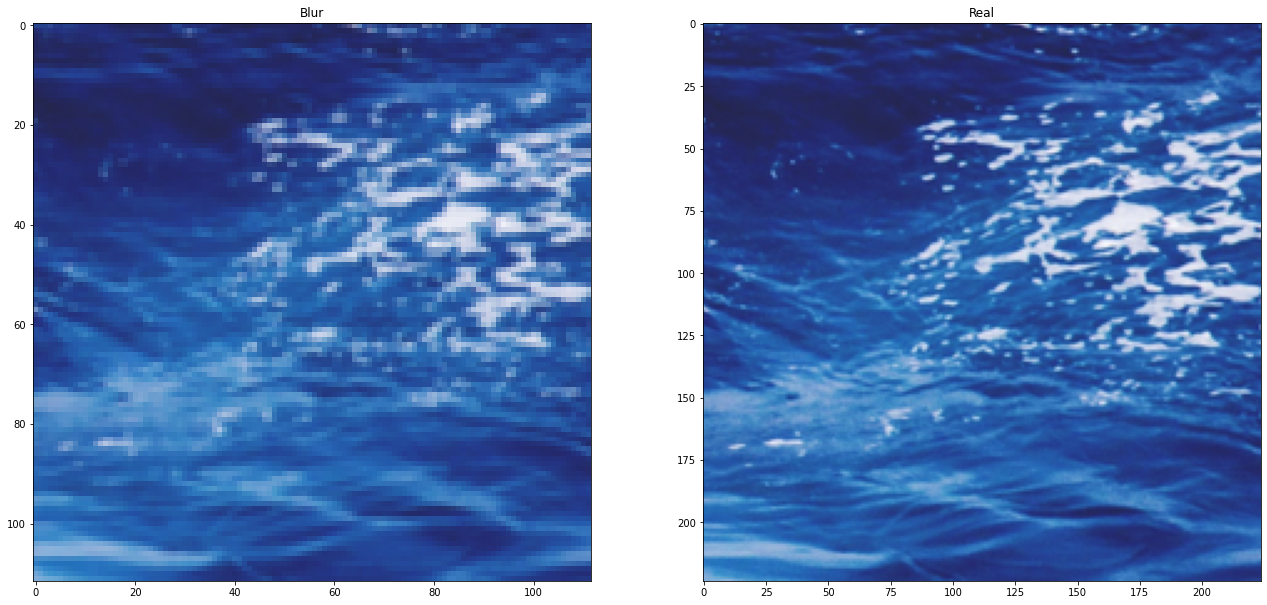

In [ ]:
image, blur_image = train_dataset[0]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(denormolize(blur_image.unsqueeze(0))[0])
plt.title('Blur')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(image.unsqueeze(0))[0])
plt.title('Real')
plt.show()

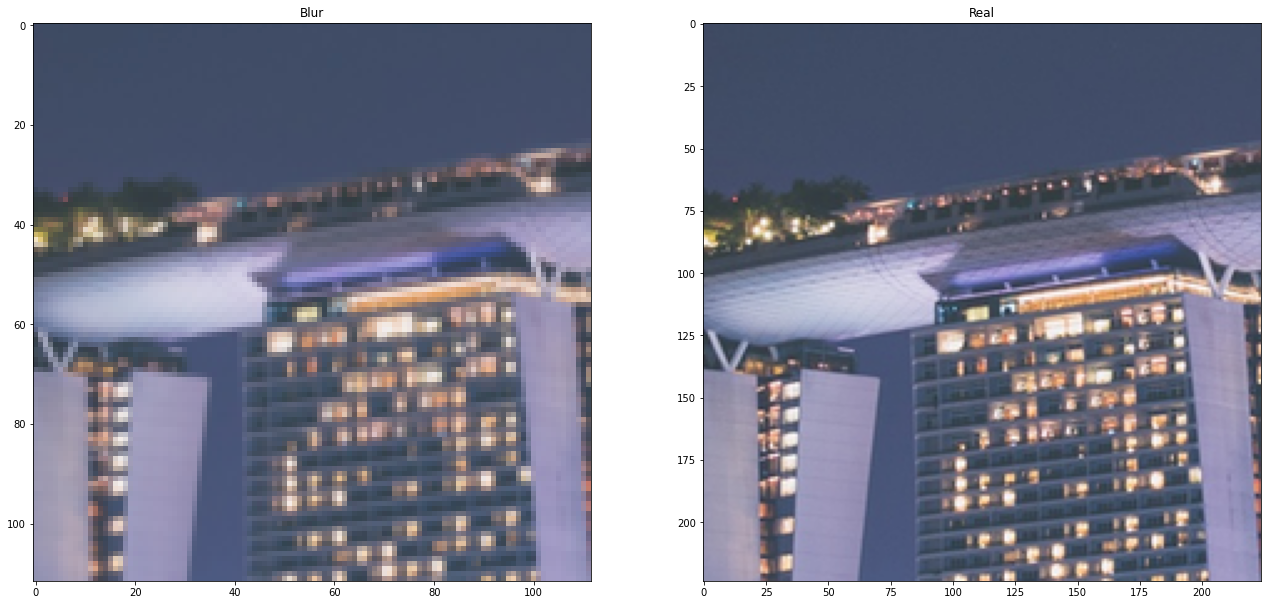

In [ ]:
image, blur_image = valid_dataset[0]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(denormolize(blur_image.unsqueeze(0))[0])
plt.title('Blur')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(image.unsqueeze(0))[0])
plt.title('Real')
plt.show()

In [ ]:
import os
os.cpu_count()

12

### Upsample example

In [ ]:
import matplotlib
from PIL import Image

from src.utils.misc import upsample_images_torch

In [ ]:
IMG_IDX = 8

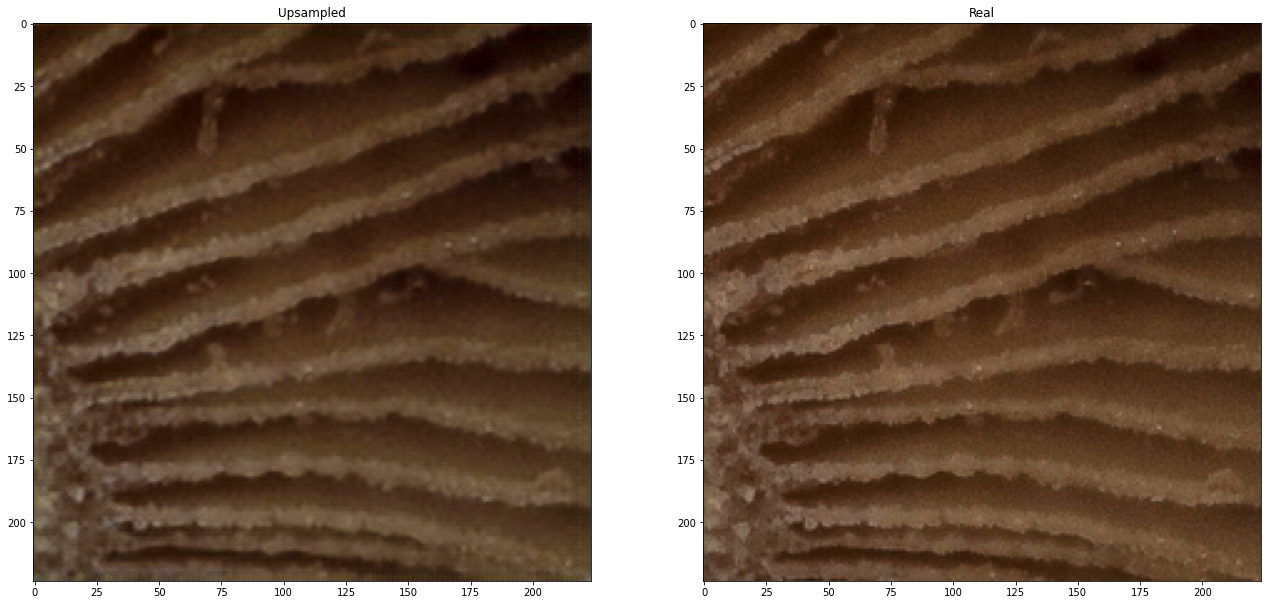

In [ ]:
real, small = valid_dataset[IMG_IDX]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(upsample_images_torch(model.generator, small)[0])
plt.title('Upsampled')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(real.unsqueeze(0))[0])
plt.title('Real')
plt.show()

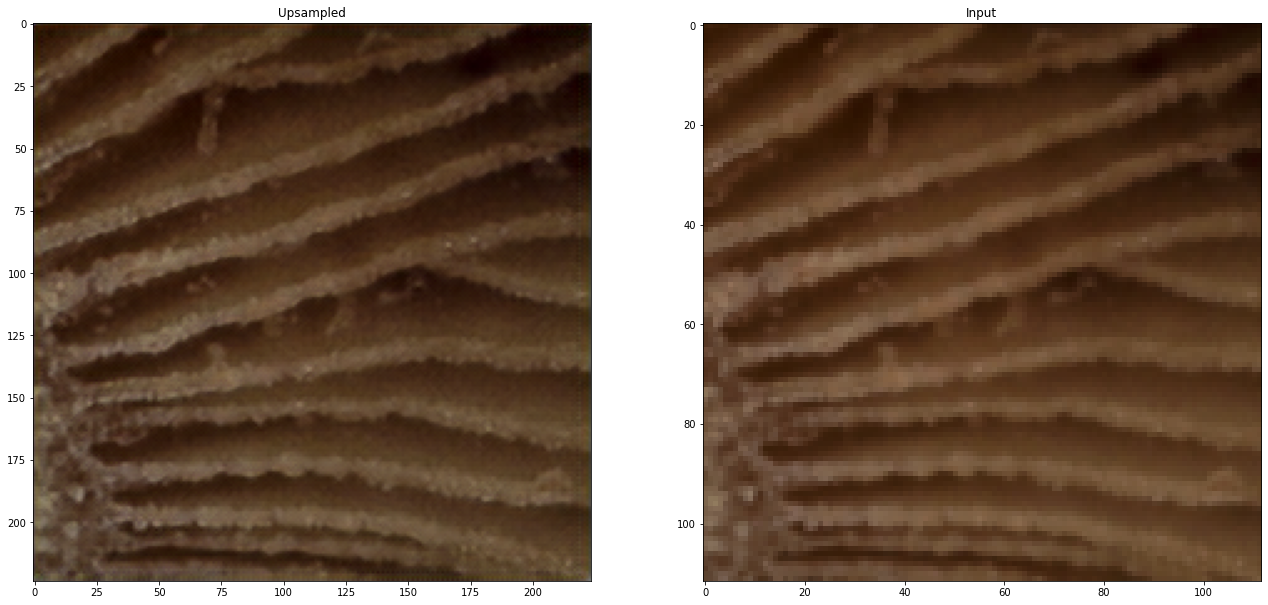

In [ ]:
real, small = valid_dataset[IMG_IDX]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(upsample_images_torch(model.generator, small)[0])
plt.title('Upsampled')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(small.unsqueeze(0))[0])
plt.title('Input')
plt.show()

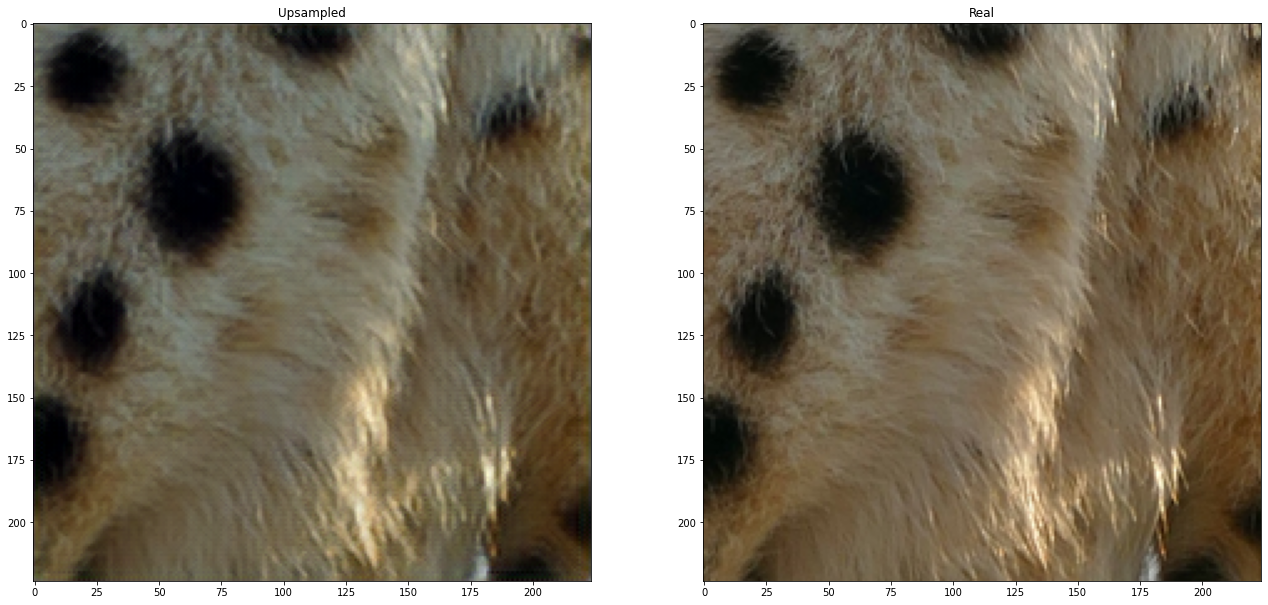

In [ ]:
real, small = valid_dataset[2]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(upsample_images_torch(model.generator, small)[0])
plt.title('Upsampled')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(real.unsqueeze(0))[0])
plt.title('Real')
plt.show()

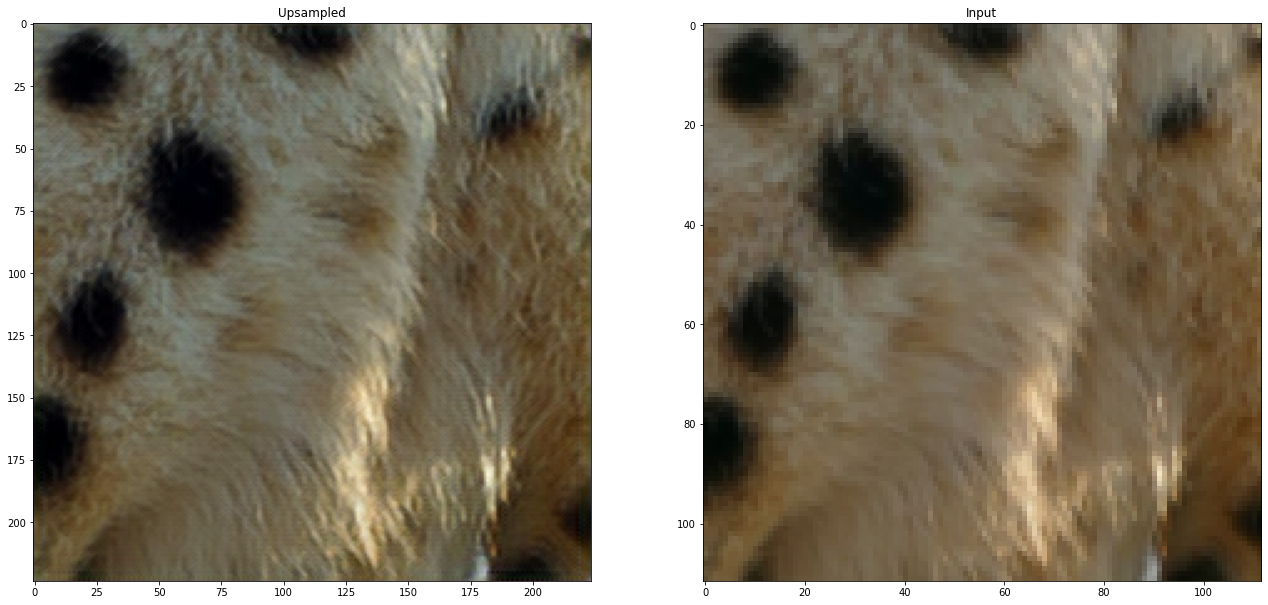

In [ ]:
real, small = valid_dataset[2]
plt.figure(figsize=(22, 20))
plt.subplot(1, 2, 1)
plt.imshow(upsample_images_torch(model.generator, small)[0])
plt.title('Upsampled')
plt.subplot(1, 2, 2)
plt.imshow(denormolize(small.unsqueeze(0))[0])
plt.title('Input')
plt.show()